# Gradient Vanishing Analysis in RESNET50 with skip connections

### Motivation

After demonstrating `vanishing gradients` in `RESNET50 (without skip connections)` we will repeat the experiment by including the skip connections.

### Approach

Replicate the original `RESNET50` model including all the skip connections and train the model.

#### Layers tracked:
- `conv1`: Early convolutional layer
- `layer1.0.conv1`: Mid-level convolutional layer
- `layer2.0.conv2`: Mid-level convolutional layer
- `layer3.5.conv3`: Deep convolutional layer
- `fc`: First fully connected layer

**Import libraries**

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from collections import defaultdict
from scipy.stats import gaussian_kde
from matplotlib.animation import FuncAnimation

**Load RESNET50 model with skip connections**

In [2]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, skip=True):
        super(Bottleneck, self).__init__()
        self.skip = skip

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.relu = nn.ReLU(inplace=True)

        self.downsample = None
        if stride != 1 or in_planes != self.expansion * planes:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))

        if self.skip:
            if self.downsample is not None:
                identity = self.downsample(identity)
            out = out + identity

        return self.relu(out)


class CustomResNet50(nn.Module):
    def __init__(self, skip=True, num_classes=10):
        super(CustomResNet50, self).__init__()
        self.in_planes = 64

        # Adjusted for CIFAR-10 (32x32): use kernel=3, stride=1, no aggressive downsampling
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.Identity()  # Optional for CIFAR-10

        self.layer1 = self._make_layer(64, 3, skip)
        self.layer2 = self._make_layer(128, 4, skip, stride=2)
        self.layer3 = self._make_layer(256, 6, skip, stride=2)
        self.layer4 = self._make_layer(512, 3, skip, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)

    def _make_layer(self, planes, blocks, skip, stride=1):
        layers = [Bottleneck(self.in_planes, planes, stride, skip)]
        self.in_planes = planes * Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(self.in_planes, planes, skip=skip))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

model = CustomResNet50(skip=True).cuda()

**Verify no. of trainable parameters**

In [3]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")

Trainable parameters: 23,520,842


**Register backward hook to log gradients**

In [4]:
selected_layers = ["conv1", "layer1.0.conv1", "layer2.0.conv2", "layer3.5.conv3", "fc"]
gradients = {}

def register_hooks(model):
    for name, module in model.named_modules():
        if name in selected_layers and (isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear)):
            gradients[name] = []
            def hook(module, grad_input, grad_output, name=name):
                gradients[name].append(grad_output[0].norm().item())
            module.register_full_backward_hook(hook)

register_hooks(model)

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_data = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)

epoch_gradients = defaultdict(list)

**Define loss and optimizer**

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

**Train the model**

In [7]:
def train(model, epochs=1):
    model.train()
    for epoch in tqdm(range(epochs)):
        # Temporary storage for one epoch
        batch_grads = defaultdict(list)

        for inputs, labels in train_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            # After backward, batch-level gradients are in global `gradients`
            for layer in selected_layers:
                if gradients[layer]:
                    batch_grads[layer].extend(gradients[layer])
                    gradients[layer].clear()  # Clear for next batch

        # Sample 20 values (or pad with zeros if less) for this epoch
        for layer in selected_layers:
            layer_grads = batch_grads[layer]
            if len(layer_grads) >= 20:
                sampled = np.random.choice(layer_grads, 20, replace=False)
            else:
                sampled = np.pad(layer_grads, (0, 20 - len(layer_grads)), constant_values=0)
            epoch_gradients[layer].append(sampled.tolist())

        print(f"Epoch {epoch+1} complete")


In [8]:
train(model, epochs=10)

 10%|█         | 1/10 [18:54<2:50:08, 1134.23s/it]

Epoch 1 complete


 20%|██        | 2/10 [37:47<2:31:11, 1133.92s/it]

Epoch 2 complete


In [12]:

layers = ['conv1', 'layer1.0.conv1', 'layer2.0.conv2', 'layer3.5.conv3', 'fc']

In [10]:
def create_log_hist_animation_matplotlib(epoch_gradients, layers, num_epochs=10, save_path='log_hist_gradients.gif'):
    fig, ax = plt.subplots(figsize=(8, 6))

    # Log-spaced bins from 1e-10 to 1e0 (1)
    log_bins = np.logspace(-10, 0, 50)

    def update(epoch):
        ax.clear()
        for layer in layers:
            data = epoch_gradients[layer][epoch]
            if len(data) > 1 and np.isfinite(data).all():
                log_data = np.abs(data) + 1e-10  # Avoid log(0)
                hist, bins = np.histogram(log_data, bins=log_bins, density=True)
                bin_centers = (bins[:-1] + bins[1:]) / 2
                ax.plot(bin_centers, hist, label=layer)

        ax.set_xscale('log')
        ax.set_xlim(1e-10, 1)
        ax.set_ylim(0, None)
        ax.set_title(f"Log-Scaled Gradient Histogram - Epoch {epoch + 1}")
        ax.set_xlabel("Gradient Magnitude (log scale)")
        ax.set_ylabel("Density")
        ax.legend()
        ax.grid(True, which="both", ls="--", linewidth=0.5)

    ani = FuncAnimation(fig, update, frames=num_epochs, repeat=False)
    ani.save(save_path, writer='pillow', fps=1)
    print(f"Saved animation to {save_path}")


Saved animation to log_hist_gradients.gif


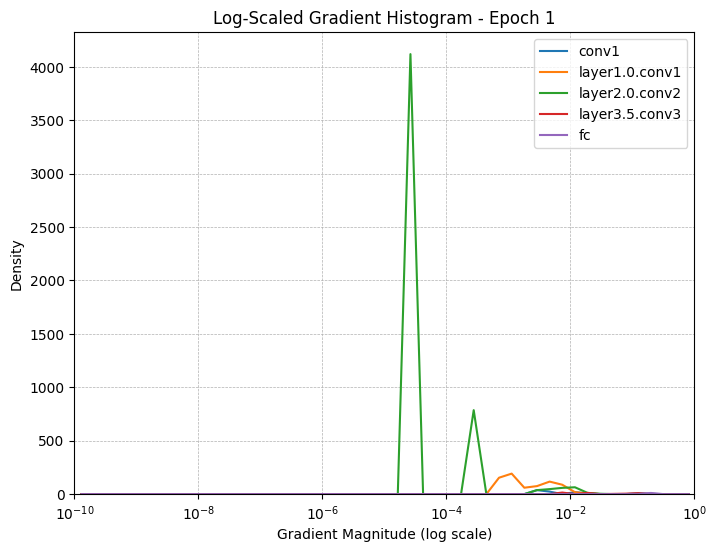

In [ ]:
# Step 3: Run it
create_log_hist_animation_matplotlib(epoch_gradients, layers, num_epochs=10, save_path='log_hist_gradients_with_skip_fixed.gif')

In [8]:
train(model, epochs=20)

  5%|▌         | 1/20 [01:09<21:56, 69.29s/it]

Epoch 1 complete


 10%|█         | 2/20 [02:18<20:45, 69.20s/it]

Epoch 2 complete


 15%|█▌        | 3/20 [03:27<19:36, 69.19s/it]

Epoch 3 complete


 20%|██        | 4/20 [04:37<18:29, 69.34s/it]

Epoch 4 complete


 25%|██▌       | 5/20 [05:46<17:19, 69.30s/it]

Epoch 5 complete


 30%|███       | 6/20 [06:55<16:09, 69.26s/it]

Epoch 6 complete


 35%|███▌      | 7/20 [08:05<15:01, 69.33s/it]

Epoch 7 complete


 40%|████      | 8/20 [09:14<13:51, 69.31s/it]

Epoch 8 complete


 45%|████▌     | 9/20 [10:23<12:43, 69.40s/it]

Epoch 9 complete


 50%|█████     | 10/20 [11:33<11:34, 69.46s/it]

Epoch 10 complete


 55%|█████▌    | 11/20 [12:42<10:24, 69.40s/it]

Epoch 11 complete


 60%|██████    | 12/20 [13:52<09:15, 69.43s/it]

Epoch 12 complete


 65%|██████▌   | 13/20 [15:01<08:06, 69.47s/it]

Epoch 13 complete


 70%|███████   | 14/20 [16:10<06:56, 69.37s/it]

Epoch 14 complete


 75%|███████▌  | 15/20 [17:20<05:46, 69.28s/it]

Epoch 15 complete


 80%|████████  | 16/20 [18:29<04:37, 69.26s/it]

Epoch 16 complete


 85%|████████▌ | 17/20 [19:38<03:27, 69.25s/it]

Epoch 17 complete


 90%|█████████ | 18/20 [20:47<02:18, 69.21s/it]

Epoch 18 complete


 95%|█████████▌| 19/20 [21:56<01:09, 69.25s/it]

Epoch 19 complete


100%|██████████| 20/20 [23:06<00:00, 69.33s/it]

Epoch 20 complete


Saved animation to log_hist_gradients_with_skip_20_epochs.gif


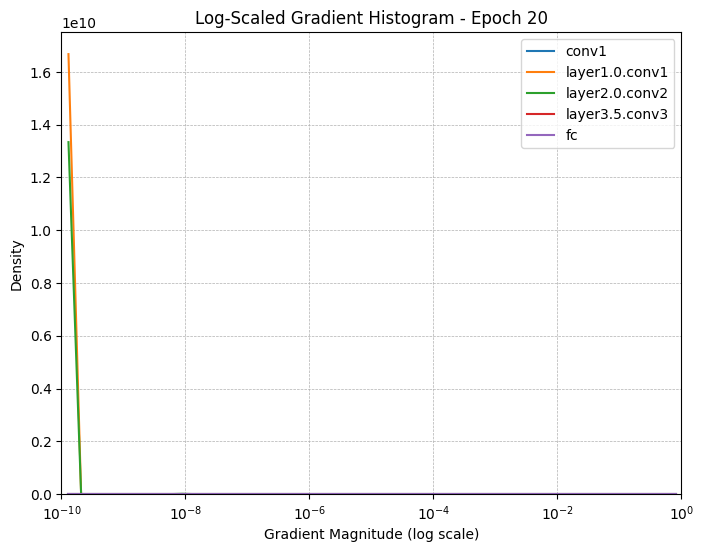

In [13]:
create_log_hist_animation_matplotlib(epoch_gradients, layers, num_epochs=20, save_path='log_hist_gradients_with_skip_20_epochs.gif')